In [1]:
# Name : Abdulaziz Alzahrani



# Exercise: Image Denoising

## Dataset Description:
- You have been given 2500 images of... cats.
- Someone has blurred some of them!
- You have train a model to unblur the images
- The train dataset only has clean images
- The test data set are the ones blurred by the intruder

## Objective:
You are tasked with implementing a U-Net architecture for image denoising/deblurring.




# Tasks:

## Preprocessing:
- Define transformations: Resize images to 64x64 pixels and convert them to tensors.
- Define your data loaders.

## U-Net Model Development:

- You are restricted to only developing a U-Net architecture.
- Ensure having skip connections.

## Training:

- Compile and train your model using the training dataset.
- You can use the blurbatch function provided below to get the blurred images on the training batches
- Choose an appropriate loss function and optimizer.
- Plot a visual representation of the decreasing loss over the training period.

## Evaluation:

Create a 2x5 figure to visually assess the model's performance. Display four distorted images alongside their corresponding denoised counterparts generated by your trained U-Net model. Here is an example:

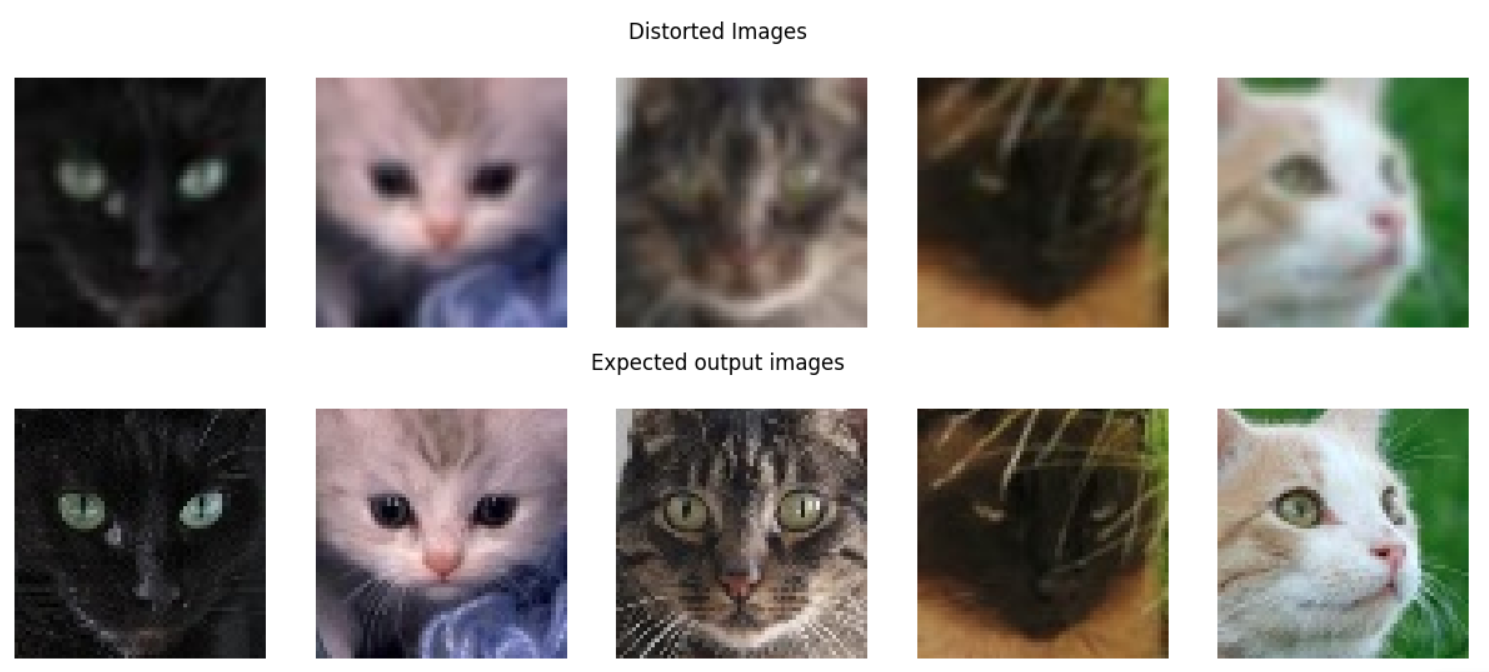

In [2]:
# Import necessary libraries
import os
import gdown
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchvision.utils

In [3]:
# URLs of the Google Drive files
url_images = 'https://drive.google.com/uc?id=1C3U2ZFaZ_-IrSMvccFORbCnDCiZnqYw0'
url_distortedFaces = 'https://drive.google.com/uc?id=16NiN8aabLj-FrxZJH4oXNhQjRs3Wfg_Z'

# Output filenames
output_images = 'cats.zip'
output_distortedFaces = 'distortedFaces.zip'

# Download the files
gdown.download(url_images, output_images, quiet=False)
gdown.download(url_distortedFaces, output_distortedFaces, quiet=False)

# Unzip the files
!unzip -q cats.zip -d./cats/
!unzip -q distortedFaces.zip -d./distortedFaces/

# Confirm the files have been unzipped
print("Files unzipped:")

Downloading...
From: https://drive.google.com/uc?id=1C3U2ZFaZ_-IrSMvccFORbCnDCiZnqYw0
To: /content/cats.zip
100%|██████████| 7.86M/7.86M [00:00<00:00, 228MB/s]
Downloading...
From: https://drive.google.com/uc?id=16NiN8aabLj-FrxZJH4oXNhQjRs3Wfg_Z
To: /content/distortedFaces.zip
100%|██████████| 3.14M/3.14M [00:00<00:00, 194MB/s]


Files unzipped:


In [4]:
print(os.listdir('./cats/cats')[:5])

['1508.jpg', '2461.jpg', '1560.jpg', '402.jpg', '2424.jpg']


In [5]:
print(os.listdir('./distortedFaces/distortedFaces')[:5])

['1508.jpg', '2461.jpg', '1560.jpg', '402.jpg', '2424.jpg']


## Begin

In [6]:
# Please fill in the "TODOs" here.
class CustomImageDatasetTrain(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.images = os.listdir(img_dir)[:2300]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


In [7]:
# Please fill in the "TODOs" here.

class CustomImageDatasetTest(Dataset):
    def __init__(self, distorted_dir, transform=None):
        self.distorted_dir = distorted_dir
        self.transform = transform
        self.distorted_images = os.listdir(distorted_dir)[2300:]

    def __len__(self):
        return len(self.distorted_images)

    def __getitem__(self, idx):
        distorted_image_name = self.distorted_images[idx]
        distorted_image_path = os.path.join(self.distorted_dir, distorted_image_name)
        distorted_image = Image.open(distorted_image_path).convert("RGB")

        if self.transform:
            distorted_image = self.transform(distorted_image)

        return distorted_image


In [8]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [9]:
train_dataset = CustomImageDatasetTrain(img_dir='./cats/cats', transform=transform)
test_dataset = CustomImageDatasetTest(distorted_dir='./distortedFaces/distortedFaces', transform=transform)


In [10]:
blur_transform = transforms.GaussianBlur(kernel_size=(3, 3), sigma=(1, 1))


def blurBatch(batch):
    blurred_images = [blur_transform(image) for image in batch]
    blurred_batch = torch.stack(blurred_images)

    return blurred_batch

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Contracting path
        self.encoder1 = self.conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self.conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self.conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self.conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

               # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)


        # Expansive Path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)


        # Output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)


    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Contracting Path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        # Bottleneck
        bottleneck = self.bottleneck(self.pool4(enc4))

        # Expansive Path
        dec4 = self.decoder4(torch.cat([self.upconv4(bottleneck), enc4], dim=1))
        dec3 = self.decoder3(torch.cat([self.upconv3(dec4), enc3], dim=1))
        dec2 = self.decoder2(torch.cat([self.upconv2(dec3), enc2], dim=1))
        dec1 = self.decoder1(torch.cat([self.upconv1(dec2), enc1], dim=1))

        # Output layer
        out = self.out(dec1)
        return out


model = UNet(in_channels=3, out_channels=3)

In [38]:


num_epochs = 5

In [48]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

train_losses = []

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

for epoch in range(num_epochs):
    epoch_weighted_loss = 0
    for i, data in enumerate(train_loader, 0):
        inputs = data
        blurred_inputs = blurBatch(inputs)
        optimizer.zero_grad()

        outputs = model(blurred_inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        epoch_weighted_loss += loss.item()*len(inputs)

        epoch_loss = epoch_weighted_loss/len(train_loader.dataset)

    scheduler.step()
print(f'epoch {epoch+1}/{num_epochs}, loss = {epoch_loss}')
epoch = epoch + 1
train_losses.append(epoch_loss)

KeyboardInterrupt: 

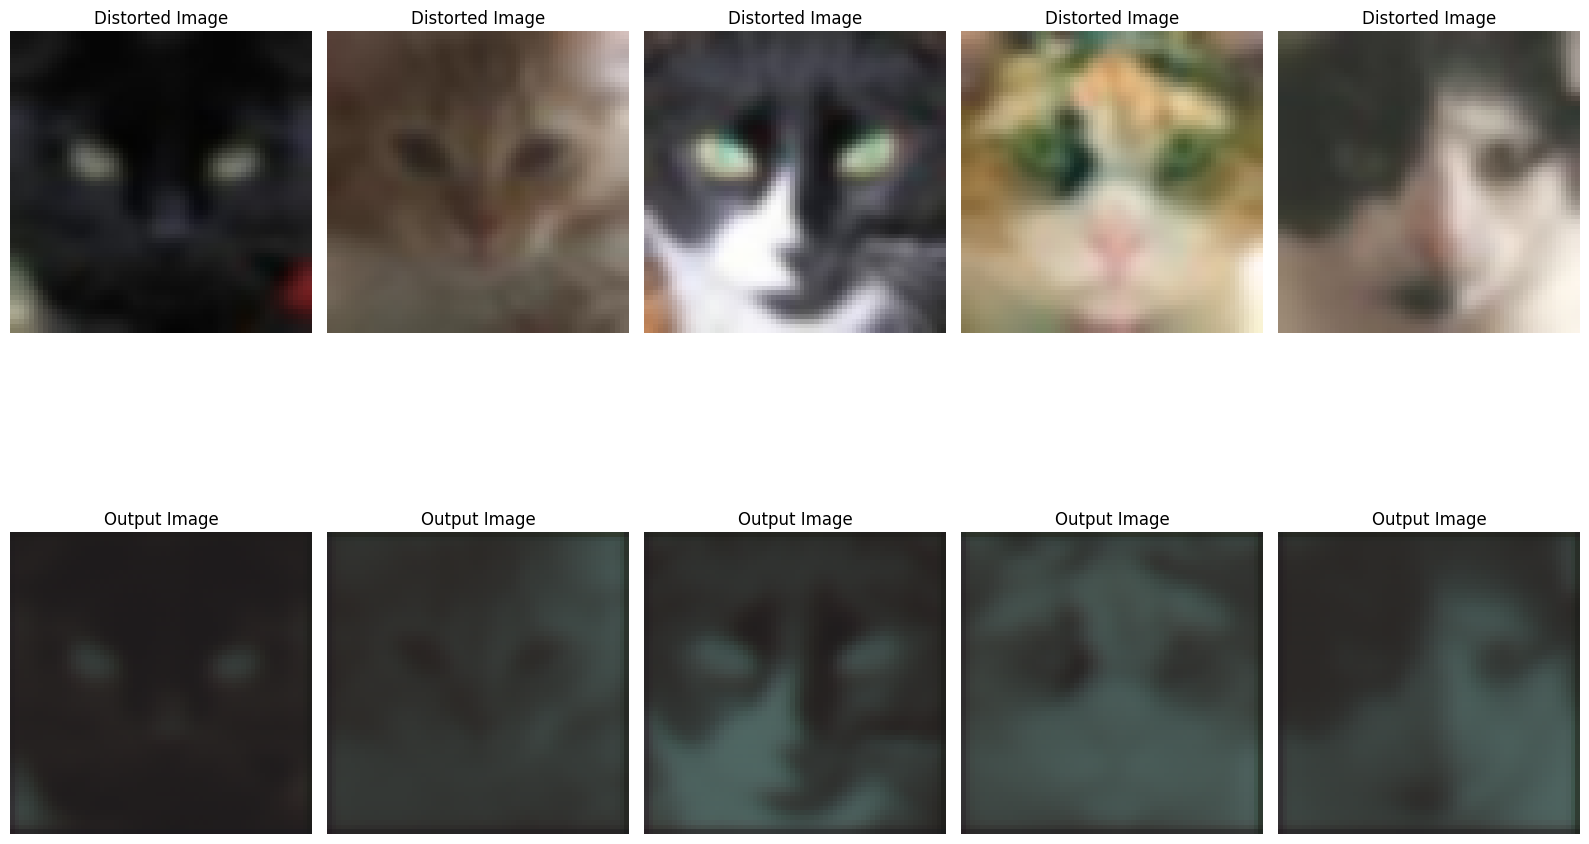

In [49]:
import matplotlib.pyplot as plt
import torch

model.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs = data
        blurred_inputs = blurBatch(inputs)
        outputs = model(inputs)

        plt.figure(figsize=(16, 12))

        for j in range(min(5, len(inputs))):
            distorted_image = blurred_inputs[j].permute(1, 2, 0)
            distorted_image = torch.clamp(distorted_image, 0, 1)
            plt.subplot(2, 5, j + 1)
            plt.imshow(distorted_image)
            plt.title("Distorted Image")
            plt.axis("off")

            output_image = outputs[j].permute(1, 2, 0)
            output_image = torch.clamp(output_image, 0, 1)
            plt.subplot(2, 5, j + 6)
            plt.imshow(output_image)
            plt.title("Output Image")
            plt.axis("off")

        plt.tight_layout()
        plt.show()

        if i == 0:
            break